# Building CNN

In [108]:
import torch
import torchvision
import torchvision.transforms as transforms

from torch import nn

import shutil
import torch.optim as optim
from tqdm.notebook import tqdm
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
import numpy as np

In [109]:
# transform = transforms.Compose(
#         [
#             transforms.ToTensor(),
#             transforms.Normalize([0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261])
#         ]
#     )
transform_train = transforms.Compose(
        [
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=30),
        transforms.RandomResizedCrop(32, scale=(0.8, 1.0), ratio=(0.8, 1.2)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261])
        ]
    )

transform_test = transforms.Compose(
        [
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261])
        ]
    )
batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


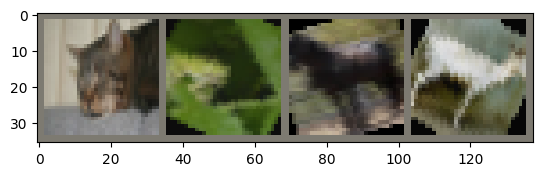

cat   frog  horse deer 


In [110]:
def imshow(img):
    std = torch.tensor([0.247, 0.243, 0.261])[:,None,None]
    mean = torch.tensor([0.4914, 0.4822, 0.4465])[:,None,None]
    img = img*std + mean   # unnormalize
    npimg = np.clip(img.numpy(), 0, 1)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
images, labels = next(iter(trainloader))

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [111]:
def train_loop(dataloader, model, loss_fn, optimizer, epoch_n, device, summary_writer):
    len_of_dataset = len(dataloader.dataset)
    batch_size = dataloader.batch_size
    num_batches = len(dataloader)

    train_loss, train_accuracy = 0, 0
    model.train()
    with tqdm(dataloader, unit='batch') as tepoch:
        for images, labels in tepoch:

            # Определяем описание для tqdm
            tepoch.set_description(f'Epoch {epoch_n}')

            images, labels = images.to(device), labels.to(device)
            # Делаем forward pass
            pred = model(images)
            # вычисляем loss
            loss = loss_fn(pred, labels)

            # Вычисляем градиенты
            optimizer.zero_grad()
            loss.backward()

            # Делаем шаг оптимизатора
            optimizer.step()

            # Вычисляем количество правильных ответов
            correct = (pred.argmax(1) == labels).sum().item()
            accuracy = correct / images.shape[0]

            # Прибавляем loss и accuracy к полным значениям за эпоху
            train_loss += loss.item()
            train_accuracy += correct
            # Выводим в tqdm текущие лосс и точность
            tepoch.set_postfix(loss=loss.item(), accuracy=accuracy)

    # вычисляем среднее
    train_loss /= num_batches
    train_accuracy /= len_of_dataset

    # Записываем в тензорборд
    summary_writer.add_scalar(
        'train/loss',
        train_loss,
        epoch_n
    )

    summary_writer.add_scalar(
        'train/accuracy',
        train_accuracy,
        epoch_n
    )

In [112]:
def test_loop(dataloader, model, loss_fn, epoch_n,  device, summary_writer):
    len_of_dataset = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    model.eval()
    # На этапе валидации нам не нужно вычислять градиенты
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            pred = model(images)
            test_loss += loss_fn(pred, labels).item()
            correct += (pred.argmax(1) == labels).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= len_of_dataset

    summary_writer.add_scalar(
        'test/loss',
        test_loss,
        epoch_n
    )

    summary_writer.add_scalar(
        'test/accuracy',
        correct,
        epoch_n
    )
    print(f'Test Metrics: \n Accuracy: {(correct):>0.3f}, Avg loss: {test_loss:>8f} \n')

In [117]:
class MyNet(nn.Module):
    def __init__(self, in_channels: int = 3, num_of_classes: int = 10):
        super(MyNet, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(6),
            nn.LeakyReLU(0.2),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=32, out_channels=120, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(120),
            nn.LeakyReLU(0.2),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=120, out_channels=196, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(196),
            nn.LeakyReLU(0.2),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=196, out_channels=240, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(240),
            nn.LeakyReLU(0.2),
            nn.AdaptiveAvgPool2d(1),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=240, out_features=180),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5),
            nn.Linear(in_features=180, out_features=94),
            nn.LeakyReLU(0.2),
            nn.Linear(in_features=94, out_features=num_of_classes),
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        probs = self.classifier(x)
        return probs

In [118]:
num_of_epochs = 30
batch_size = 32
learning_rate = 0.001

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
net = MyNet()
net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

shutil.rmtree('runs/mynet', ignore_errors=True)
writer = SummaryWriter('runs/mynet')
for epoch_n in range(num_of_epochs):
    train_loop(trainloader, net, criterion, optimizer, epoch_n, device, writer)
    test_loop(testloader, net, criterion, epoch_n, device, writer)
print("Done!")

cuda


  0%|          | 0/1563 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.453, Avg loss: 1.522010 



  0%|          | 0/1563 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.507, Avg loss: 1.340386 



  0%|          | 0/1563 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.555, Avg loss: 1.229975 



  0%|          | 0/1563 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.554, Avg loss: 1.211626 



  0%|          | 0/1563 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.598, Avg loss: 1.132592 



  0%|          | 0/1563 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.622, Avg loss: 1.070010 



  0%|          | 0/1563 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.644, Avg loss: 0.989022 



  0%|          | 0/1563 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.639, Avg loss: 1.017897 



  0%|          | 0/1563 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.667, Avg loss: 0.948403 



  0%|          | 0/1563 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.683, Avg loss: 0.914541 



  0%|          | 0/1563 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.662, Avg loss: 0.958304 



  0%|          | 0/1563 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.694, Avg loss: 0.880237 



  0%|          | 0/1563 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.662, Avg loss: 0.975581 



  0%|          | 0/1563 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.696, Avg loss: 0.860822 



  0%|          | 0/1563 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.702, Avg loss: 0.858676 



  0%|          | 0/1563 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.709, Avg loss: 0.846346 



  0%|          | 0/1563 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.697, Avg loss: 0.848962 



  0%|          | 0/1563 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.712, Avg loss: 0.819225 



  0%|          | 0/1563 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.705, Avg loss: 0.846159 



  0%|          | 0/1563 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.715, Avg loss: 0.812775 



  0%|          | 0/1563 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.719, Avg loss: 0.810679 



  0%|          | 0/1563 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.729, Avg loss: 0.769108 



  0%|          | 0/1563 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.717, Avg loss: 0.817958 



  0%|          | 0/1563 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.731, Avg loss: 0.772532 



  0%|          | 0/1563 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.734, Avg loss: 0.755075 



  0%|          | 0/1563 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.731, Avg loss: 0.766015 



  0%|          | 0/1563 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.733, Avg loss: 0.752886 



  0%|          | 0/1563 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.733, Avg loss: 0.758999 



  0%|          | 0/1563 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.737, Avg loss: 0.741957 



  0%|          | 0/1563 [00:00<?, ?batch/s]

Test Metrics: 
 Accuracy: 0.738, Avg loss: 0.746833 

Done!


In [120]:
torch.save(net, "model.pth")